In [3]:
import pickle
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sksurv.preprocessing import OneHotEncoder as SurvOneHotEncoder
from sksurv.util import Surv

from sksurv.column import encode_categorical
from sksurv.column import standardize

pd.set_option('display.max_rows', 500)

### IDEAS
- remove NPKID: use only recipients with no previous transplants

In [4]:
pickle_file = 'data/COX_DATA_FULL_LIVING.pkl'

with open(pickle_file, 'rb') as f:
    living = pickle.load(f)

living.drop(['DIAG_KI', 'COD_KI'], axis=1, inplace=True)

In [5]:
pickle_file = 'data/DATA_DECEASED.pkl'

with open(pickle_file, 'rb') as f:
    deceased = pickle.load(f)

In [26]:
print("living: ", living.shape)
print("deceased: ", deceased.shape)

living:  (52420, 56)
deceased:  (117568, 19)


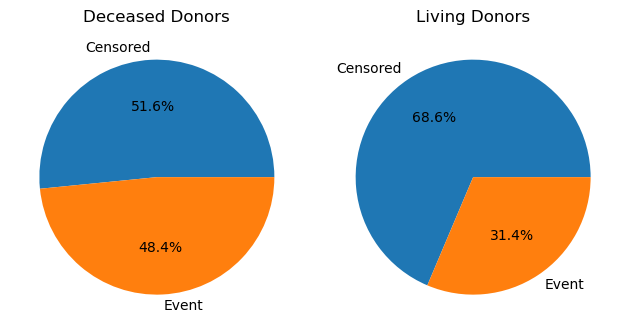

In [14]:
import matplotlib.pyplot as plt

# Create a figure and two subplots
fig, (ax1, ax2) = plt.subplots(1, 2)

# Plot on the first subplot
deceased_counts = deceased['PSTATUS'].value_counts()
ax1.pie(deceased_counts, labels=["Censored", "Event"], autopct='%1.1f%%')
ax1.set_title('Deceased Donors')

# Plot on the second subplot
living_counts = living['PSTATUS'].value_counts()
ax2.pie(living_counts, labels=["Censored", "Event"], autopct='%1.1f%%')
ax2.set_title('Living Donors')

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()


In [27]:
numeric_deceased = [
    "AGE",
    "BMI_CALC",
    "AGE_DON",
    "CREAT_TRR",
    "NPKID",
    "COLD_ISCH_KI",
]
categorical_deceased = [
    "ON_DIALYSIS",
    "PRE_TX_TXFUS",
    "GENDER",
    "ETHCAT",
    "DIABETES_DON",
    "DIAB",
    "HCV_SEROSTATUS",
]
categorical_living=["PRE_TX_TXFUS", 
                "GENDER",
                "ON_DIALYSIS", 
                "ABO_MAT", 
                "ETHCAT", 
                "ETHCAT_DON",
                'HBV_CORE', 
                'DIAB',
                'HCV_SEROSTATUS',  
                'LIV_DON_TY',
]
numerical_living = [   
                "KI_CREAT_PREOP",
                "SERUM_CREAT",
                "NPKID", 
                "AGE", 
                "HGT_CM_CALC", 
                "BMI_DON_CALC",
                "AGE_DON"]

In [37]:

deceased[numeric_deceased].describe().T

,count,mean,std,min,25%,50%,75%,max
AGE,117568.0,51.883259,13.112097,18.0,43.00,53.00,62.0,90.0
BMI_CALC,117568.0,27.770096,5.419293,15.0,23.80,27.30,31.3,72.2
AGE_DON,117568.0,38.101618,16.595043,0.0,24.00,40.00,51.0,88.0
CREAT_TRR,117568.0,8.251785,3.508183,0.1,5.70,7.82,10.3,28.2
NPKID,117568.0,0.122083,0.361227,0.0,0.00,0.00,0.0,5.0
COLD_ISCH_KI,117568.0,18.016163,8.981343,0.0,11.87,17.00,23.0,99.0


In [51]:
desc = deceased[numeric_deceased].describe().T
table = desc.to_latex(caption="Descriptive Statistics for Numerical Variables in Deceased Donor Group", label="tab:desc_deceased", )
# print(table)

In [52]:
desc_living = living[numerical_living].astype("float").describe().T
desc_living = desc_living.round(2)
table_living = desc_living.to_latex(caption="Descriptive Statistics for Numerical Variables in Living Donor Group", label="tab:desc_living", )
# print(table_living)

# 

categorical_deceased = [
    "ON_DIALYSIS", ynu
    "PRE_TX_TXFUS",ynu
    "DIABETES_DON", ynu

    "GENDER", mf
    
    "HCV_SEROSTATUS", N/ND/P (filter NDs)
    "ETHCAT", # better in table
    "DIAB", # better in a table
]

1. ynu table
2. ethcat table
3. pie: gender, hcv, diab - done

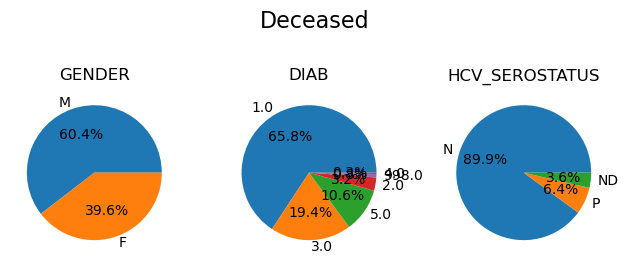

In [92]:
import matplotlib.pyplot as plt

# Create a figure and two subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)


# Plot on the first subplot
deceased_counts = deceased['GENDER'].value_counts()
ax1.pie(deceased_counts, labels=deceased_counts.index, autopct='%1.1f%%')
ax1.set_title('GENDER')

# Plot on the second subplot
transfusions = deceased['DIAB'].value_counts()
ax2.pie(transfusions, labels=transfusions.index, autopct='%1.1f%%') # todo: add labels
ax2.set_title('DIAB')

gender = deceased['HCV_SEROSTATUS'].value_counts()
ax3.pie(gender, labels=gender.index, autopct='%1.1f%%')
ax3.set_title("HCV_SEROSTATUS")

fig.suptitle('Deceased', y=0.80, fontsize=16)

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

categorical_living=["PRE_TX_TXFUS", # ynu
                "ON_DIALYSIS",  #ynu

                "GENDER", #mf
                
                "ABO_MAT",  # unique values: maybe pie?

                "ETHCAT", # table 
                "ETHCAT_DON", # same table

                'HBV_CORE', # N/ND/P (filter NDs)
                'HCV_SEROSTATUS', # N/ND/P (filter NDs)

                'DIAB', # better in a table
                
                'LIV_DON_TY', # better in a table

## Living tables
1. ynu table - yes
2. Ethncat table - yes
3. N/P table

pie: Diab, gender, liv_don_type, abo_mat
4. Diab table, pie?
5. Liv don type table pie?
6. ABO mat - pie?


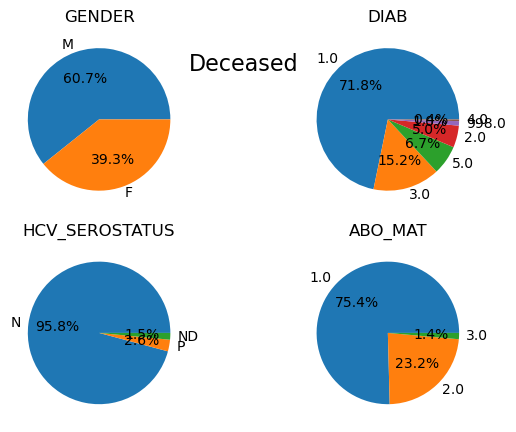

In [95]:
import matplotlib.pyplot as plt

# Create a figure and two subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)


# Plot on the first subplot
deceased_counts = living['GENDER'].value_counts()
ax1.pie(deceased_counts, labels=deceased_counts.index, autopct='%1.1f%%')
ax1.set_title('GENDER')

# Plot on the second subplot
transfusions = living['DIAB'].value_counts()
ax2.pie(transfusions, labels=transfusions.index, autopct='%1.1f%%') # todo: add labels
ax2.set_title('DIAB')

gender = living['HCV_SEROSTATUS'].value_counts()
ax3.pie(gender, labels=gender.index, autopct='%1.1f%%')
ax3.set_title("HCV_SEROSTATUS")

abo = living['ABO_MAT'].value_counts()
ax4.pie(abo, labels=abo.index, autopct='%1.1f%%')
ax4.set_title("ABO_MAT")

fig.suptitle('Deceased', y=0.80, fontsize=16)

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()